# ML Pipeline Preparation

### 1. Import libraries and load data from database.

In [3]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import nltk
import joblib

In [4]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
import pickle

In [6]:
# load data from database
engine = create_engine('sqlite:///data/DisasterResponse.db')
df = pd.read_sql('df',con=engine)
X = df['message']
y = df.drop(['id','message','original','genre'],axis=1)
category_names = y.columns

### 2. Tokenization function to process text data

In [7]:
def tokenize(text):
    word = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_token = []
    for token in word:
        lem_tok = lemmatizer.lemmatize(token).lower().strip()
        clean_token.append(lem_tok)
        
    return clean_token

### 3. Building a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset.

In [8]:
pipeline = Pipeline([

        ('vect',CountVectorizer(tokenizer=tokenize)),
        ('tfidf',TfidfTransformer()),
        ('clf',MultiOutputClassifier(RandomForestClassifier(n_estimators=100)))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [11]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

In [12]:
pred = pipeline.predict(X_test)

### 5. Testing model

In [13]:
performances = []
for i in range(len(category_names)):
        performances.append([f1_score(y_test.iloc[:, i].values, pred[:, i], average='micro'),
                             precision_score(y_test.iloc[:, i].values, pred[:, i], average='micro'),
                             recall_score(y_test.iloc[:, i].values, pred[:, i], average='micro')])

In [14]:
performances = pd.DataFrame(performances, columns=['f1 score', 'precision', 'recall'],
                                index = category_names)

In [15]:
performances

,f1 score,precision,recall
related,0.801038,0.801038,0.801038
request,0.894873,0.894873,0.894873
offer,0.995117,0.995117,0.995117
aid_related,0.768691,0.768691,0.768691
medical_help,0.921880,0.921880,0.921880
medical_products,0.948276,0.948276,0.948276
search_and_rescue,0.975130,0.975130,0.975130
security,0.980470,0.980470,0.980470
military,0.970552,0.970552,0.970552
child_alone,1.000000,1.000000,1.000000


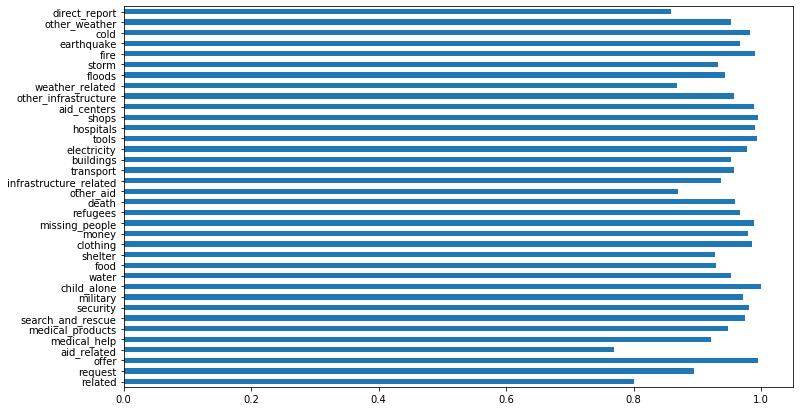

In [30]:
plt.figure(figsize=(12,7))
performances['f1 score'].plot(kind='barh');

### 6. Improving model
Using grid search to find better parameters. 

In [124]:
parameters = {
              'clf__estimator__max_features':['sqrt', 0.5],
              'clf__estimator__n_estimators':[50, 100]}

cv = GridSearchCV(estimator=pipeline, param_grid = parameters, cv = 5)

In [126]:
cv.fit(X_train,y_train)

In [129]:
cv.best_params_

In [32]:
joblib.dump(pipeline,'models/model.pkl')

['models/model.pkl']